# CONTENT LIST

1. Importing libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: Decomposition
4. Testing for stationarity
5. Stationarizing the Data

# 01. Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
# Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
#feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. 

In [2]:
path = r'C:\Users\chery\Desktop\CareerFoundry\Immersion Data Analytics\Achievement 6'

In [3]:
# Import DF

df = pd.read_pickle(os.path.join(path, '04-2021 PPP Loan Analysis','02 Data', 'Prepared Data','Task 6.3 Merged.pkl'))

In [4]:
df.head(5)

,STATE_NAME,STATE_FIPS,STATE_ABBR,geometry,loan_amount,city,zip,industry_code,business_type,business_owner_race,business_owner_gender,business_owner_vet_status,jobs_reported,date_loan_approved,lender,congressional_district,_merge
0,Washington,53,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",149992.0,Bellingham,98225.0,nan,Subchapter S Corporation,NaN,NaN,NaN,11.0,05/01/2020,"JPMorgan Chase Bank, National Association",WA-02,both
1,Washington,53,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",149980.0,Spokane Valley,99216.0,621210.0,Limited Liability Company(LLC),NaN,NaN,NaN,12.0,04/29/2020,Banner Bank,WA-05,both
2,Washington,53,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",149975.0,Kirkland,98033.0,339999.0,Subchapter S Corporation,NaN,NaN,NaN,6.0,04/16/2020,Seattle Bank,WA-01,both
3,Washington,53,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",149950.0,Port Orchard,98367.0,238210.0,Limited Liability Company(LLC),NaN,NaN,NaN,10.0,06/13/2020,"Kabbage, Inc.",WA-06,both
4,Washington,53,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",149922.0,Burlington,98233.0,999990.0,Subchapter S Corporation,NaN,NaN,NaN,12.0,05/03/2020,Cross River Bank,WA-02,both


In [5]:
df.shape

(4200172, 17)

In [6]:
df.columns

Index(['STATE_NAME', 'STATE_FIPS', 'STATE_ABBR', 'geometry', 'loan_amount',
       'city', 'zip', 'industry_code', 'business_type', 'business_owner_race',
       'business_owner_gender', 'business_owner_vet_status', 'jobs_reported',
       'date_loan_approved', 'lender', 'congressional_district', '_merge'],
      dtype='object')

# 02. Subsetting, wrangling, and cleaning time-series data

### Time Series 1 - Jobs Reported

In [7]:
#Create subset for only columns necessary for time series #1

df_jobs = df[['date_loan_approved','jobs_reported']]

In [8]:
df_jobs.head()

,date_loan_approved,jobs_reported
0,05/01/2020,11.0
1,04/29/2020,12.0
2,04/16/2020,6.0
3,06/13/2020,10.0
4,05/03/2020,12.0


In [12]:
# Set the "date_loan_approved" column as the index

from datetime import datetime

df_jobs['datetime'] = pd.to_datetime(df_jobs['date_loan_approved']) # Create a datetime column from "Date.""
df_jobs = df_jobs.set_index('datetime') # Set the datetime as the index of the dataframe.
df_jobs.drop(['date_loan_approved'], axis=1, inplace=True) # Drop the "Date" column.

df_jobs.head()

,jobs_reported
datetime,
2020-05-01,11.0
2020-04-29,12.0
2020-04-16,6.0
2020-06-13,10.0
2020-05-03,12.0


In [14]:
#Group data by 'datetime' to make smaller df for analysis

df_jobs_group = df_jobs.groupby('datetime').agg({'jobs_reported': ['sum']})

In [15]:
df_jobs_group.head()

,jobs_reported
,sum
datetime,
2020-04-03,130073.0
2020-04-04,248254.0
2020-04-05,267150.0
2020-04-06,442783.0
2020-04-07,615883.0


In [42]:
df_jobs_group.columns

MultiIndex([('jobs_reported', 'sum')],
           )

In [43]:
#Rename column

df_jobs_group.rename(columns={'sum':'Total Jobs Reported'})

,jobs_reported
,Total Jobs Reported
datetime,
2020-04-03,130073.0
2020-04-04,248254.0
2020-04-05,267150.0
2020-04-06,442783.0
2020-04-07,615883.0
...,...
2020-08-04,36449.0
2020-08-05,43521.0


In [46]:
df_jobs_group.shape

(114, 1)

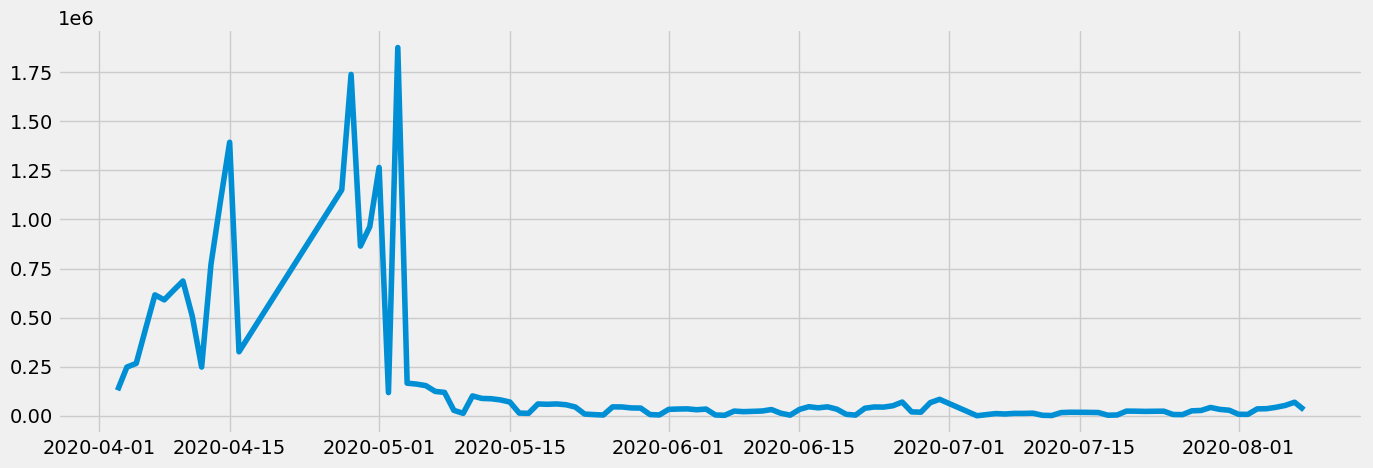

In [47]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_jobs_group)

In [61]:
# Check for missing values 

df_jobs_group.isnull().sum() 

# No missing values

jobs_reported  sum    0
dtype: int64

In [49]:
# Check for duplicates

dups = df_jobs_group.duplicated()
dups.sum()

# No dupes

0

### Time Series 2 - Loan Amount

In [22]:
#Create subset for only columns necessary for time series #2

df_loan = df [['date_loan_approved','loan_amount']]

In [23]:
df_loan.head()

,date_loan_approved,loan_amount
0,05/01/2020,149992.0
1,04/29/2020,149980.0
2,04/16/2020,149975.0
3,06/13/2020,149950.0
4,05/03/2020,149922.0


In [24]:
df_loan.shape

(4200172, 2)

In [25]:
# Set the "date_loan_approved" column as the index

from datetime import datetime

df_loan['datetime'] = pd.to_datetime(df_loan['date_loan_approved']) # Create a datetime column from "Date.""
df_loan = df_loan.set_index('datetime') # Set the datetime as the index of the dataframe.
df_loan.drop(['date_loan_approved'], axis=1, inplace=True) # Drop the "Date" column.

df_loan.head()

,loan_amount
datetime,
2020-05-01,149992.0
2020-04-29,149980.0
2020-04-16,149975.0
2020-06-13,149950.0
2020-05-03,149922.0


In [26]:
#Group data by 'datetime' to make smaller df for analysis

df_loan_group = df_loan.groupby('datetime').agg({'loan_amount': ['sum']})

In [27]:
df_loan_group.head()

,loan_amount
,sum
datetime,
2020-04-03,8.597196e+08
2020-04-04,1.659699e+09
2020-04-05,1.824616e+09
2020-04-06,2.985790e+09
2020-04-07,4.193028e+09


In [50]:
df_loan_group.columns

MultiIndex([('loan_amount', 'sum')],
           )

In [51]:
#Rename column

df_loan_group.rename(columns={'sum':'Total Loan Amount'})

,loan_amount
,Total Loan Amount
datetime,
2020-04-03,8.597196e+08
2020-04-04,1.659699e+09
2020-04-05,1.824616e+09
2020-04-06,2.985790e+09
2020-04-07,4.193028e+09
...,...
2020-08-04,3.075470e+08
2020-08-05,3.571041e+08


In [52]:
df_loan_group.shape

(114, 1)

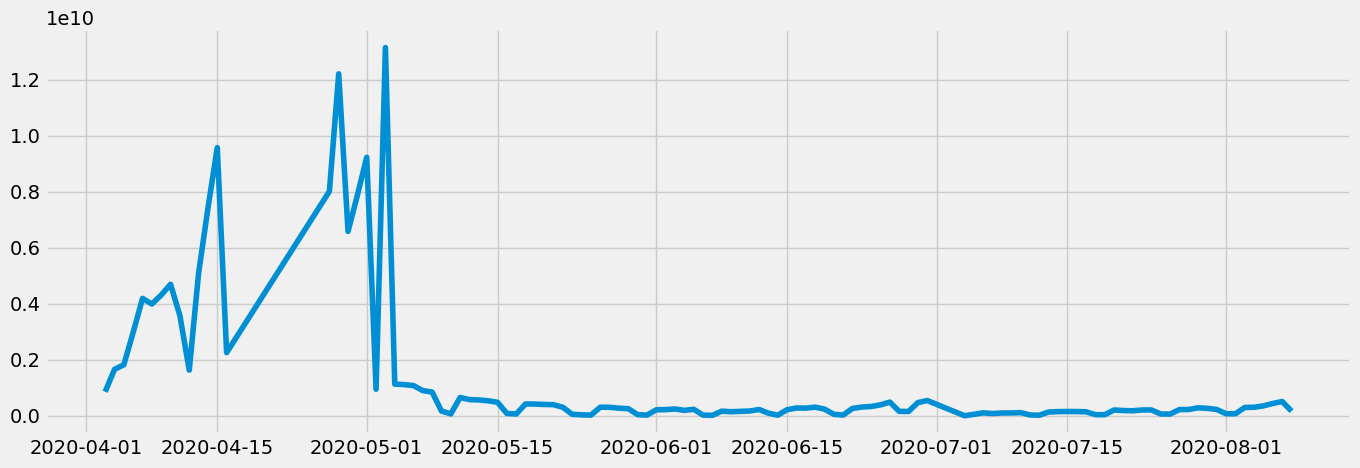

In [53]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_loan_group)

In [30]:
# Check for missing values 

df_loan_group.isnull().sum() 

# No missing values

loan_amount  sum    0
dtype: int64

In [31]:
# Check for duplicates

dups = df_loan_group.duplicated()
dups.sum()

# No dupes

0

# 03. Time series analysis: Decomposition

### Decomposition 1 - Jobs Reported

In [54]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_jobs_group, model='additive', period=12)

In [55]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

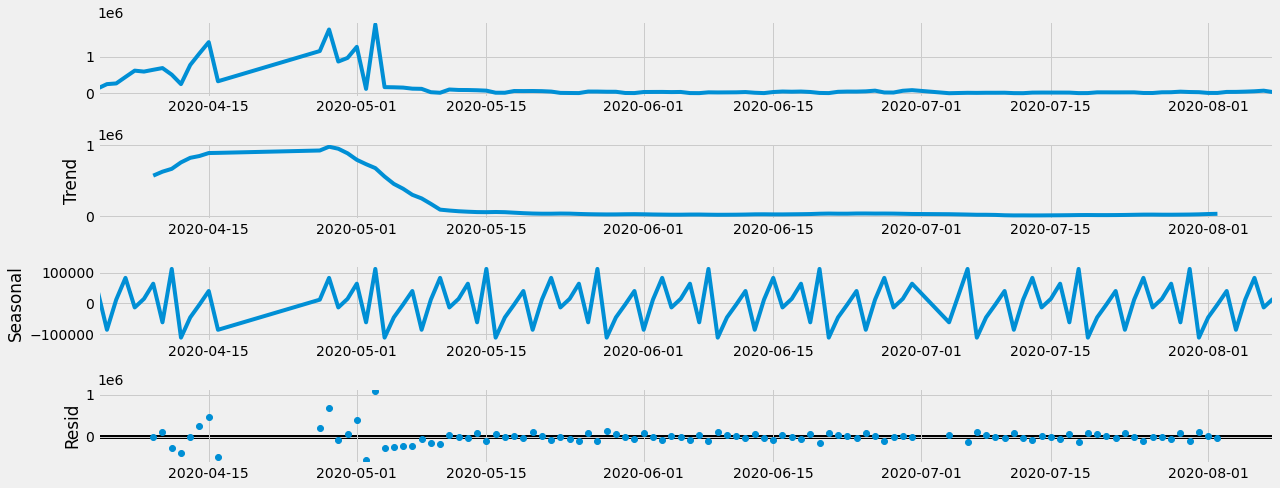

In [56]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Level & trend differ, especially between 2020-04-01 and 2020-05-15 confirming unsmoothed data. Supporting this statement, there is a lot of noise (resid) seen during these dates. After 2020-05-15 a fairly stable dominant trend is seen.

### Decomposition 2 - Loan Amount

In [57]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_loan_group, model='additive', period=12)

In [58]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

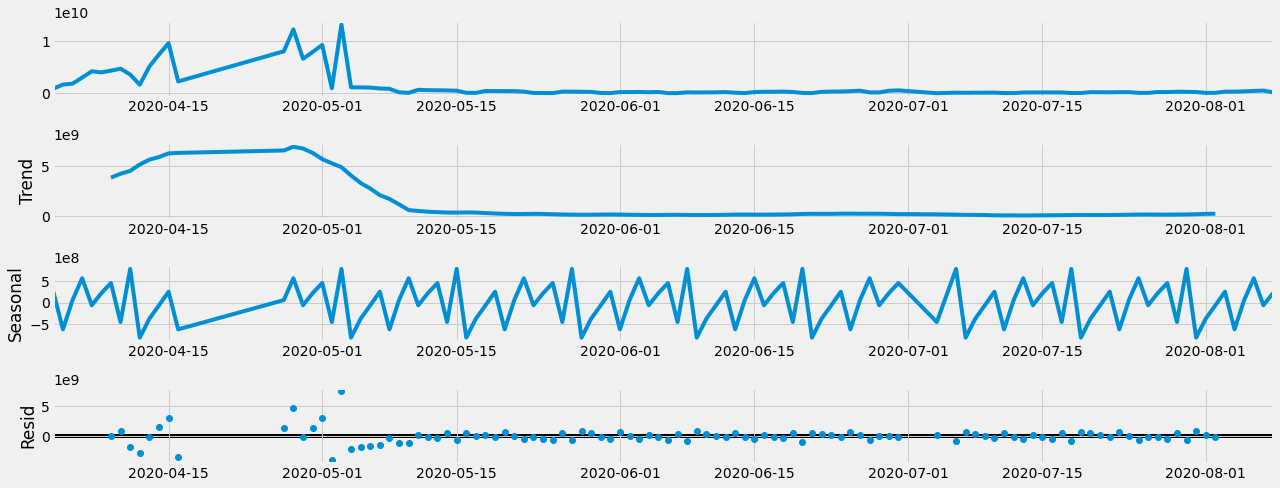

In [59]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Similar to the above decomposition : Level & trend differ, especially between 2020-04-01 and 2020-05-15 confirming unsmoothed data. Supporting this statement, there is a lot of noise (resid) seen during these dates. After 2020-05-15 a fairly stable dominant trend is seen.

# 04. Testing for Stationarity

### Test 1 - Jobs Reported

In [63]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_jobs_group['jobs_reported'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.907193
p-value                          0.328685
Number of Lags Used              9.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


#### Test statistic larger than critical value so cannot reject null hypothesis (cannot reject statement that data is stationary)

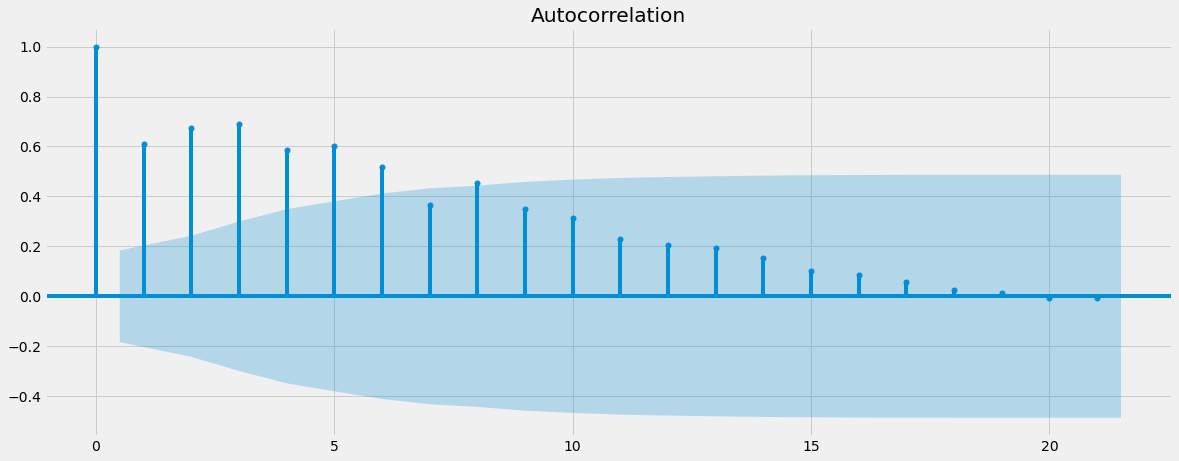

In [64]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_jobs_group)
plt.show()

#### Several blue lines outside of blue area (confidence interval) representing lags that are significantly correlated with each other. This, along with the Dickey-Fuller results, implies that the data is non-stationary.

### Test 2 - Loan Amounts

In [66]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_loan_group['loan_amount'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.780680
p-value                          0.390095
Number of Lags Used              9.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


#### Test statistic larger than critical value so cannot reject null hypothesis (cannot reject statement that data is stationary)

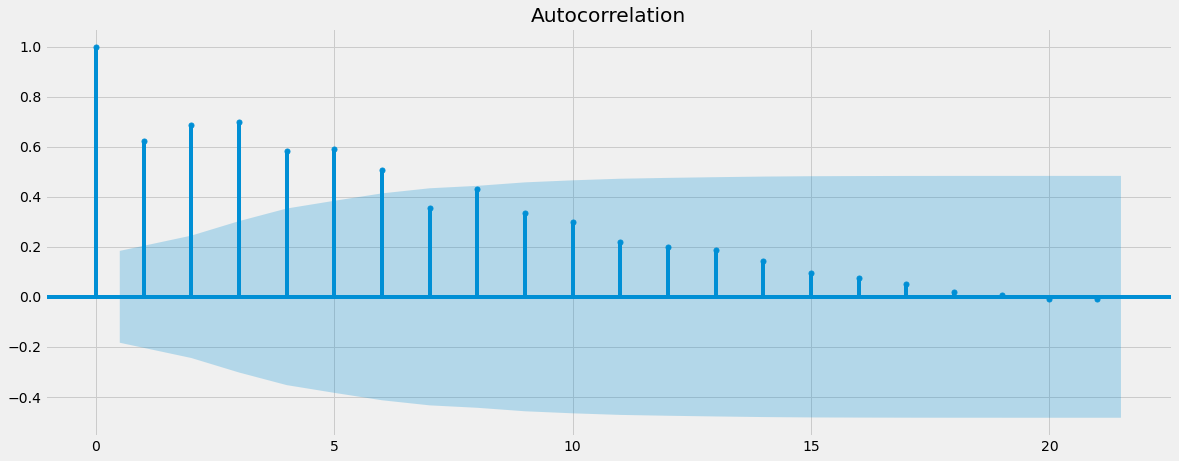

In [67]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_loan_group)
plt.show()

#### Several blue lines outside of blue area (confidence interval) representing lags that are significantly correlated with each other. This, along with the Dickey-Fuller results, implies that the data is non-stationary.

# 05. Stationarizing

### Differencing 1 - Jobs Reported

In [68]:
diff_jobs = df_jobs_group - df_jobs_group.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [69]:
diff_jobs.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [70]:
diff_jobs.head()

,jobs_reported
,sum
datetime,
2020-04-04,118181.0
2020-04-05,18896.0
2020-04-06,175633.0
2020-04-07,173100.0
2020-04-08,-25318.0


In [71]:
diff_jobs.columns

MultiIndex([('jobs_reported', 'sum')],
           )

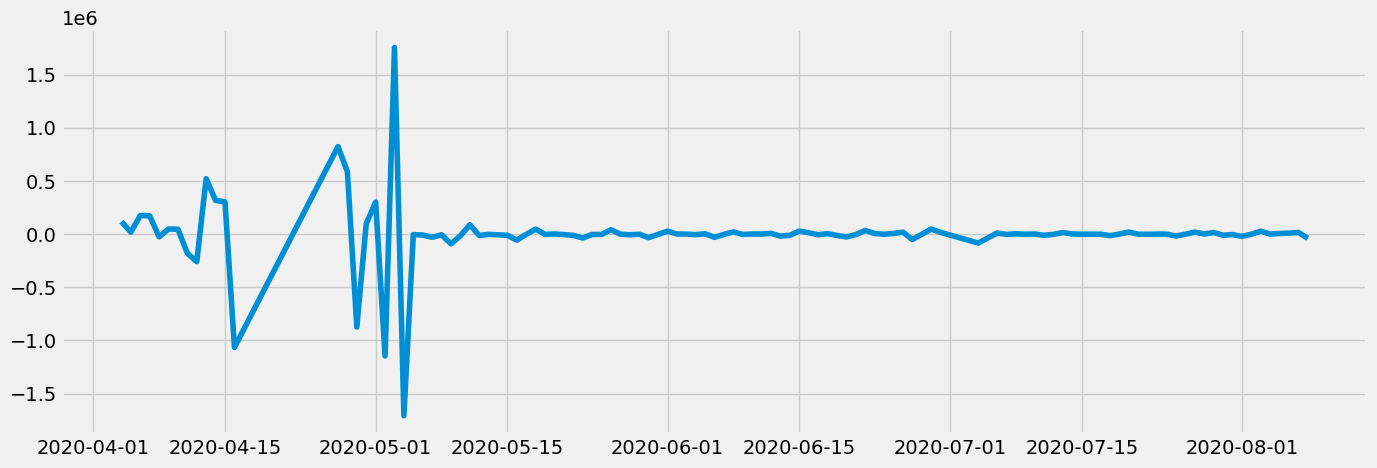

In [72]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(diff_jobs)

In [73]:
dickey_fuller(diff_jobs)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.526351
p-value                          0.007336
Number of Lags Used              8.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


#### Test statistic now smaller than critical value so CAN reject null hypothesis (can reject statement that data is stationary)

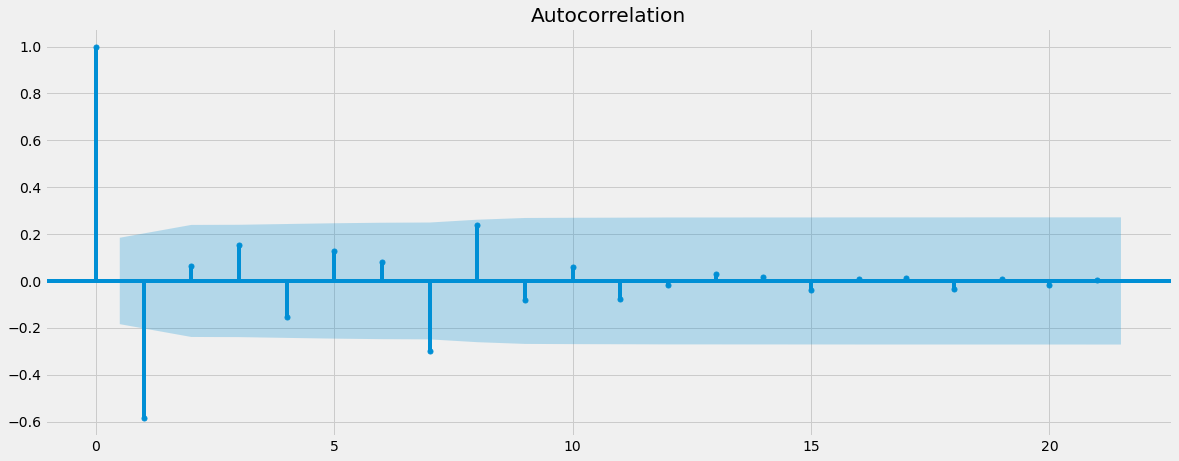

In [74]:
plot_acf(diff_jobs)
plt.show()

#### Much fewer blue lines outside of blue area now implying that the data is stationary.

### Differencing 2 - Loan Amount

In [75]:
diff_loan = df_loan_group - df_loan_group.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [76]:
diff_loan.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [77]:
diff_loan.head()

,loan_amount
,sum
datetime,
2020-04-04,7.999791e+08
2020-04-05,1.649174e+08
2020-04-06,1.161175e+09
2020-04-07,1.207238e+09
2020-04-08,-2.009353e+08


In [78]:
diff_loan.columns

MultiIndex([('loan_amount', 'sum')],
           )

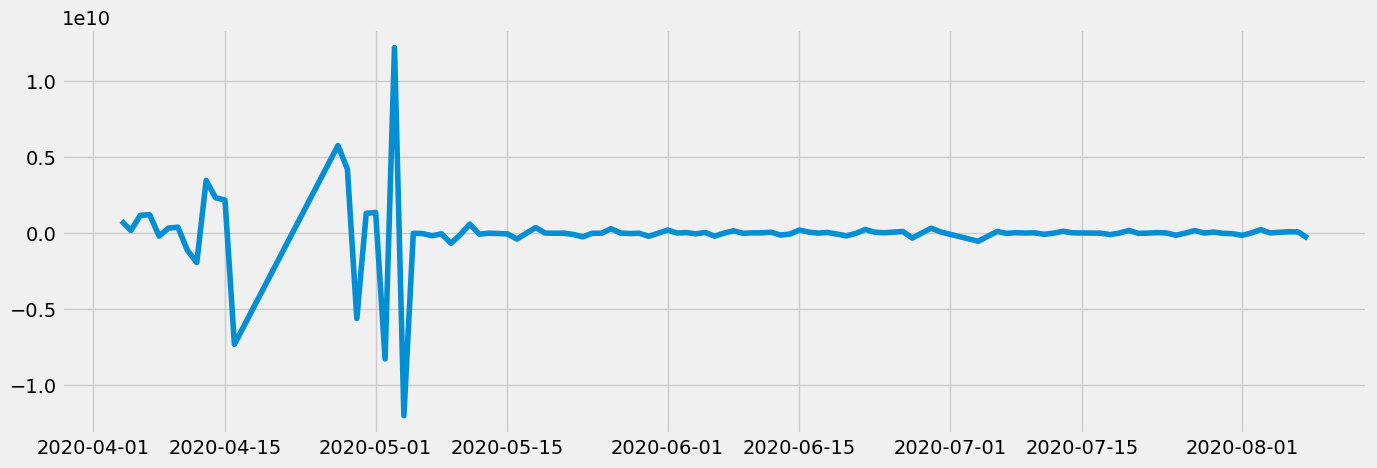

In [79]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(diff_loan)

In [80]:
dickey_fuller(diff_loan)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.904982
p-value                          0.001998
Number of Lags Used              8.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


#### Test statistic now smaller than critical value so CAN reject null hypothesis (can reject statement that data is stationary)

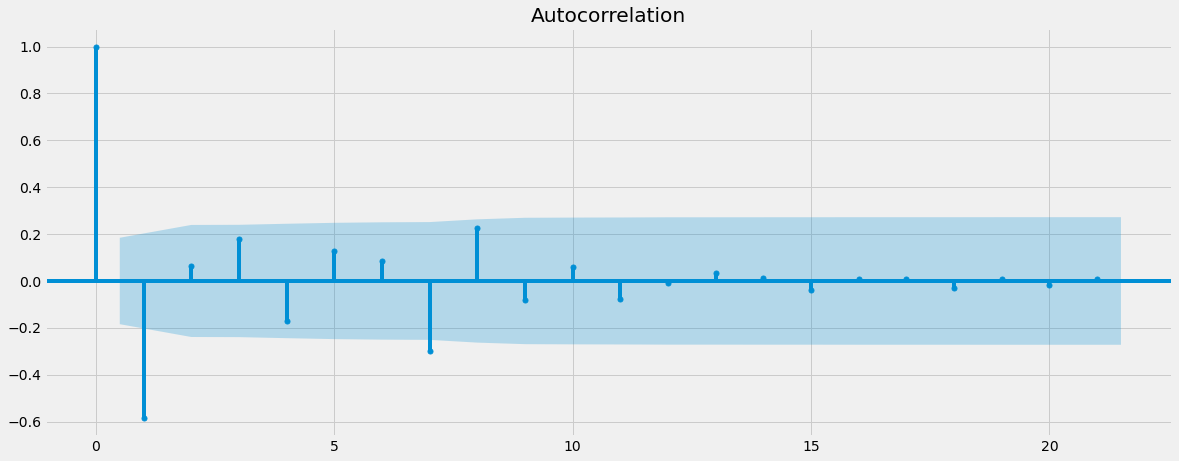

In [81]:
plot_acf(diff_loan)
plt.show()

#### Much fewer blue lines outside of blue area now implying that the data is stationary.